In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
msg = tf.constant(f'TensorFlow {tf.__version__} Hello World')
tf.print(msg)

TensorFlow 2.12.0 Hello World


In [ ]:
gpu_available = tf.config.list_physical_devices('GPU')
gpu_available

[]

In [ ]:
# just some library to manipulate the data
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#_URL = '/content/drive/MyDrive/Inteligencia_Artificial/ComidasFiltro'

_URL = '/content/drive/MyDrive/ComidasFiltro'
#https://drive.google.com/uc?id=1JzJxaQU9dtXXmLMcTCwZbEAu-48yxsYz&export=download'
#path_to_zip = tf.keras.utils.get_file('ComidasFiltro.zip', origin=_URL, extract=True,cache_dir='/content')
#PATH = os.path.join(os.path.dirname(path_to_zip), 'ComidasFiltro')

train_dir = '/content/drive/MyDrive/ComidasFiltro/train'
#train_dir = '/content/drive/MyDrive/Inteligencia_Artificial/ComidasFiltro/train'
print(train_dir);
validation_dir = '/content/drive/MyDrive/ComidasFiltro/validation'
test_dir = '/content/drive/MyDrive/ComidasFiltro/test'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)



/content/drive/MyDrive/ComidasFiltro/train


In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 44 files belonging to 2 classes.


In [ ]:
train_dataset.class_names

['No Saludable', 'Saludable']

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 96 files belonging to 2 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 24 files belonging to 2 classes.


In [ ]:
validation_dataset.class_names
#val_batches = tf.data.experimental.cardinality(validation_dataset)
#print('Number of batches: %d' % val_batches)

['No Saludable', 'Saludable']

In [ ]:
#test_dataset = validation_dataset.take(val_batches // 5)
#validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
#print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
#print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

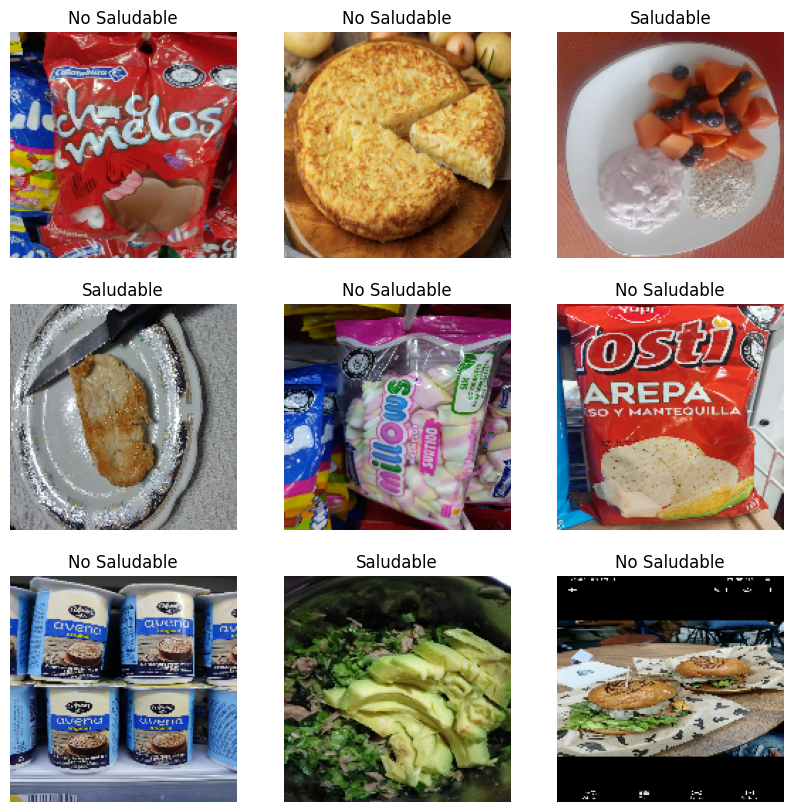

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#se establece el proceso de analisis de fotografias rotacional
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.2) )
])

tf.Tensor([1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0], shape=(32,), dtype=int32)
(160, 160, 3)


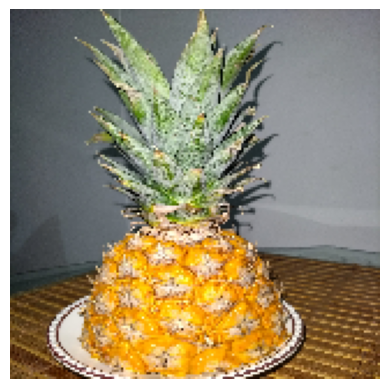

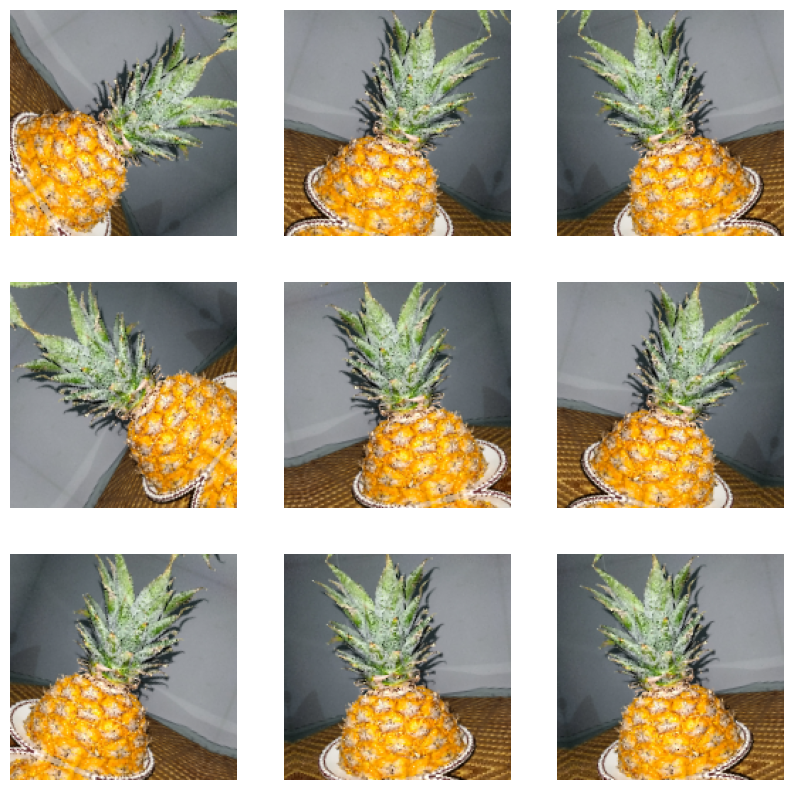

In [ ]:
#Selección aletoriedad de una fotografia a evaluar
for image, output in train_dataset.take(1):
  plt.figure()
  print(output)
  first_image = image[0]
  plt.imshow(first_image / 255)
  plt.axis('off')
  print(first_image.shape)
  #visualización del tamaño seleccionada
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#entrenamiento de modelos
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [ ]:
#proceso de alamacenamiento y validacion del dato seleccionado
print(base_model.summary())
#tf.keras.utils.plot_model(base_model, to_file='model.png')

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

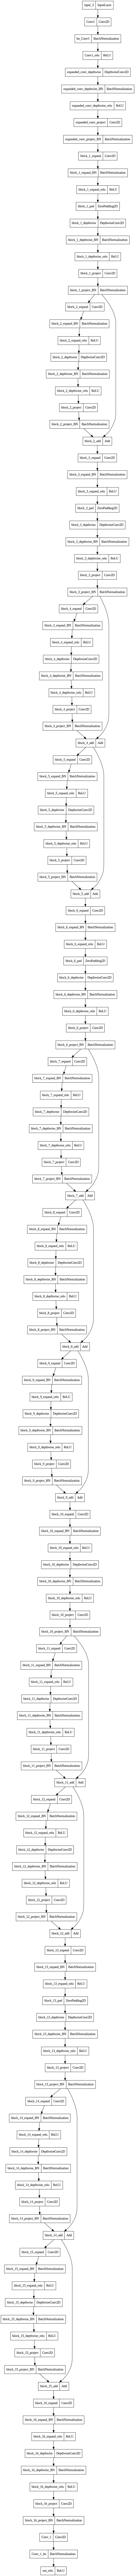

In [ ]:
#proceso de modelado
tf.keras.utils.plot_model(base_model, to_file='model.png')

In [ ]:
#conversion de imagenes
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


**TRANSFER LEARNING**

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Entrenar el nuevo modelo

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 3)                 3843

In [ ]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

3/3 [==============================] - 6s 521ms/step - loss: 1.4313 - accuracy: 0.3438
initial loss: 1.43
initial accuracy: 0.34


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
2/2 [==============================] - 13s 5s/step - loss: 1.1836 - accuracy: 0.3636 - val_loss: 1.3789 - val_accuracy: 0.3542
Epoch 2/100
2/2 [==============================] - 13s 11s/step - loss: 1.1417 - accuracy: 0.4773 - val_loss: 1.3326 - val_accuracy: 0.3646
Epoch 3/100
2/2 [==============================] - 8s 7s/step - loss: 1.2609 - accuracy: 0.3864 - val_loss: 1.2899 - val_accuracy: 0.3646
Epoch 4/100
2/2 [==============================] - 6s 4s/step - loss: 1.2181 - accuracy: 0.4091 - val_loss: 1.2505 - val_accuracy: 0.3958
Epoch 5/100
2/2 [==============================] - 7s 5s/step - loss: 1.1126 - accuracy: 0.5000 - val_loss: 1.2141 - val_accuracy: 0.3958
Epoch 6/100
2/2 [==============================] - 8s 5s/step - loss: 1.0800 - accuracy: 0.4773 - val_loss: 1.1805 - val_accuracy: 0.4271
Epoch 7/100
2/2 [==============================] - 12s 11s/step - loss: 1.0793 - accuracy: 0.4318 - val_loss: 1.1496 - val_accuracy: 0.4375
Epoch 8/100
2/2 [============

Text(0.5, 1.0, 'Training and Validation Accuracy')

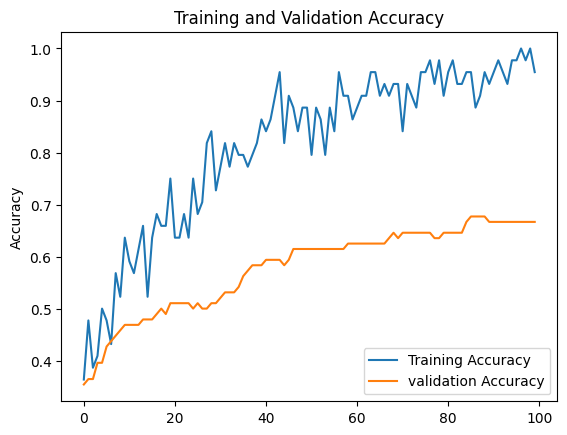

In [ ]:
#validacion de datos en data de comparativas y visualizacion de procesos
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy','validation Accuracy'],loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')


In [ ]:
model.save('final_model.h5')

In [ ]:
base_model.trainable = True

capas_bloqueadas =len(base_model.layers)- 10

for layer in base_model.layers[:capas_bloqueadas]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
import PIL

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 3)                 3843

Entrenar de nuevo

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 100/110
2/2 [==============================] - 12s 11s/step - loss: 0.0634 - accuracy: 1.0000 - val_loss: 0.7266 - val_accuracy: 0.7188
Epoch 101/110
2/2 [==============================] - 7s 5s/step - loss: 0.0489 - accuracy: 1.0000 - val_loss: 0.7316 - val_accuracy: 0.7188
Epoch 102/110
2/2 [==============================] - 7s 5s/step - loss: 0.0402 - accuracy: 1.0000 - val_loss: 0.7426 - val_accuracy: 0.7188
Epoch 103/110
2/2 [==============================] - 13s 11s/step - loss: 0.0440 - accuracy: 1.0000 - val_loss: 0.7381 - val_accuracy: 0.7188
Epoch 104/110
2/2 [==============================] - 7s 5s/step - loss: 0.0362 - accuracy: 1.0000 - val_loss: 0.7357 - val_accuracy: 0.7188
Epoch 105/110
2/2 [==============================] - 7s 5s/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.7400 - val_accuracy: 0.7188
Epoch 106/110
2/2 [==============================] - 12s 10s/step - loss: 0.0322 - accuracy: 1.0000 - val_loss: 0.7475 - val_accuracy: 0.7188
Epoch 107/110


Text(0.5, 1.0, 'Training and Validation Accuracy')

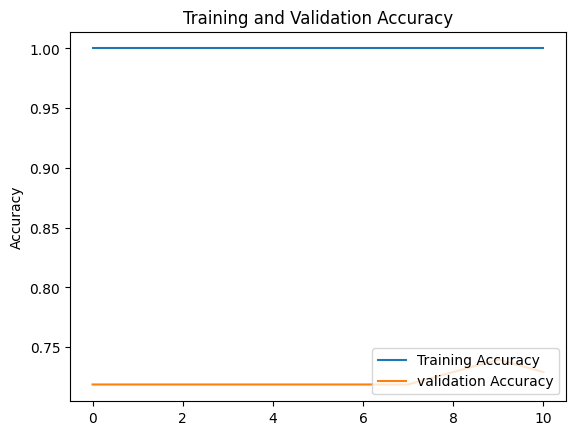

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.legend(['Training Accuracy','validation Accuracy'],loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

In [ ]:
model.save('final_model.h5')

Test

Predictions:
 tf.Tensor([1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0], shape=(24,), dtype=int64)
Labels:
 [1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1]


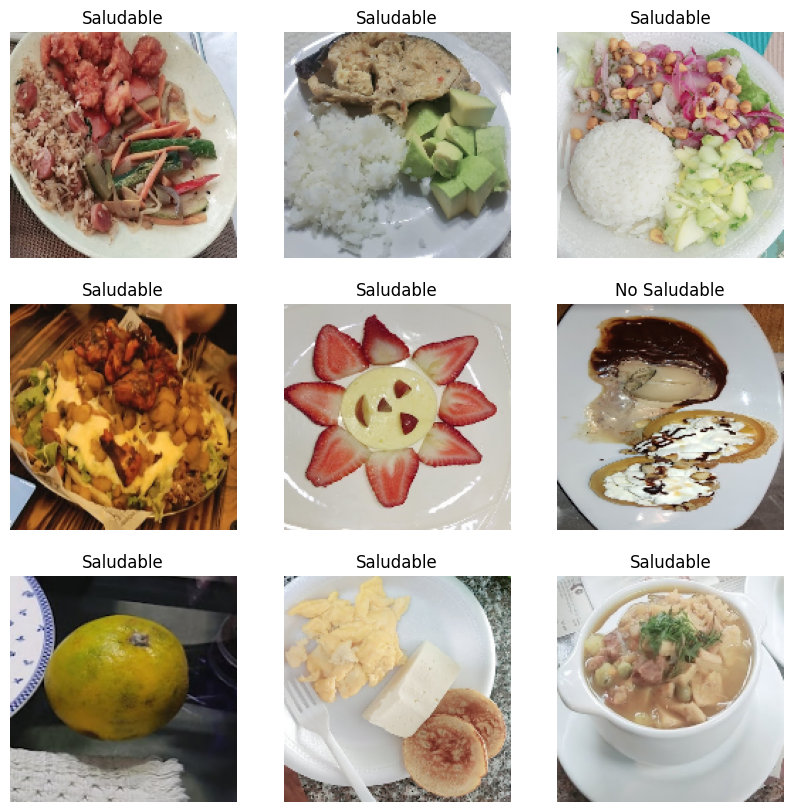

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.softmax(predictions)
predictions= tf.argmax(predictions,axis=1)#tf.where(predictions < 0.5, 0, 1)



print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
import PIL
prueba='1.png'


---------------------------------------------------------------

1/1 [==============================] - 0s 77ms/step
tf.Tensor([[9.8282832e-01 1.7000912e-02 1.7076118e-04]], shape=(1, 3), dtype=float32)


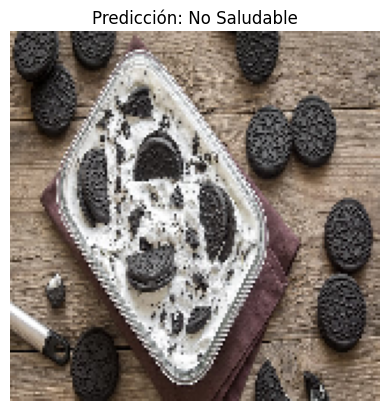

In [ ]:
import PIL

# Limpiar el caché eliminando el archivo descargado previamente, si existe
cache_dir = os.path.expanduser('~/.keras/datasets')
cache_file = os.path.join(cache_dir, 'dato')
if os.path.exists(cache_file):
    os.remove(cache_file)

#Variable que se debe cambiar sí se va a seleccionar otro alimento
my_url="https://images.hola.com/imagenes/cocina/recetas/20190621144428/helado-casero-galletas-oreo/0-693-923/helado-galletas-oreo-t.jpg"

#Extraer imagen
prueba = tf.keras.utils.get_file('dato', origin=my_url)
img = tf.keras.utils.load_img(
    prueba, target_size=IMG_SIZE
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#Predicción
predictions = model.predict(img_array)
predictions = tf.nn.softmax(predictions)
print(predictions)
clasification=class_names[np.argmax(predictions)]

# Mostrar la imagen
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicción: {clasification}')
plt.show()


In [ ]:

#https://images.hola.com/imagenes/cocina/recetas/20190621144428/helado-casero-galletas-oreo/0-693-923/helado-galletas-oreo-t.jpg
#https://www.alqueria.com.co/sites/default/files/2021-12/CH_Fotos_Lasa%C3%B1a-sin-horno_1400x700.jpg

#SALUDABLE
#https://img.freepik.com/foto-gratis/camarones-plancha-ensalada-verduras-frescas-comida-sana-endecha-plana-ensalada-caprese-italiana-tomates-albahaca-mozzarella-ingredientes-ensalada-caprese-tradicional-italiana-ensalada-griega-mediterranea_1150-44795.jpg
#https://www.mercadoscampesinos.gov.co/wp-content/uploads/2022/08/Naranaja-tangelo-organica.jpg
